# Solve the moments

## Prepare

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import sys

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
Tanh = np.tanh
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

from helperFunctions import alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='20')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')

In [2]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/wall-velocity/model/'
sys.path.append(model_directory)
import baseMo_s_b_d as bm

### Load a benchmark

In [3]:
m = bm.model(702.654702269, -102.146250858, 0.112009439661, 0.0037322807528, -0.0370639674565,10000)
m.findAllTransitions()
hv = m.TnTrans[0]['high_vev']
lv = m.TnTrans[0]['low_vev']
Tnuc = m.TnTrans[0]['Tnuc']
Vtot = m.Vtot

Tracing phase starting at x = [246.00000051 572.58176356] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...........................................................................................................................................................................
Tracing phase starting at x = [-2.27347289e-07  1.79312356e+02] ; t = 68.27354525855334
Tracing minimum down
traceMinimum t0 = 68.2735
..............................................................................
Tracing minimum up
traceMinimum t0 = 68.2735
..............................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [77]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

def find_Tsh(Tm, vw):
    guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.1,Tnuc])
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max*0.9999)
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

def find_Tsh_hyb(Tm, vw):
    guess_sol = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.4,Tnuc])
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max*0.9999)
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [79]:
find_Tsh_hyb(60,0.6)

array(63.76135702)

In [80]:
optimize.newton(lambda T: find_Tsh_hyb(T, 0.6)-Tnuc, 62)

57.56635608916657

In [82]:
Tm=57.56635608916657
vp, Tp = optimize.fsolve(lambda x:match(x[0], cs_sq(Vtot, Tm, lv)**0.5, x[1], Tm,hv, lv),[0.4,Tnuc])
hv_new = m.findMinimum(hv, Tp)
lv_new = m.findMinimum(lv, Tm)

In [65]:
vw = 0.5
Tm = optimize.newton(lambda T: find_Tsh(T, vw) - Tnuc, Tnuc-1)
vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
hv_new = m.findMinimum(hv, Tp)
lv_new = m.findMinimum(lv, Tm)

In [83]:
Tm

57.56635608916657

## Load field value profile

In [84]:
h0 = lv_new[0]
s0 = lv_new[1]-hv_new[1]
s_initial=hv_new[1]
def h_profile(z,Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz

def s_profile(z, Ls, deltas):
    z = np.asanyarray(z)
    sz = 0.5*s0*(1-np.tanh(z/Ls + deltas)) + s_initial
    return sz

def dh(z, Lh):
    z = np.asanyarray(z)
    return -0.5*(h0*Sech(z/Lh)**2)/Lh

def ds(z, Ls, deltas):
    z = np.asanyarray(z)
    return -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls

def d2h(z, Lh):
    z = np.asanyarray(z)
    return (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2

def d2s(z, Ls, deltas):
    z = np.asanyarray(z)
    return (s0*Sech(deltas + z/Ls)**2*Tanh(deltas + z/Ls))/Ls**2

c1 = w(Vtot, Tm, lv_new) * vw/(1-vw**2)
s1=c1
c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vw**2 /(1-vw**2)
s2=c2

def T33(T,z, Lh, Ls, deltas):
    derh = dh(z, Lh)
    ders = ds(z, Ls, deltas)
    field_value = [h_profile(z, Lh), s_profile(z, Ls, deltas)]
    return (0.5*(derh**2 + ders**2) - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

## Calculate moments

In [85]:
def moments(Lh, Ls, deltas):
    npoints = 100
    z_range = np.linspace(-8*max(Lh,Ls), 5*max(Lh,Ls), npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), 55, method='Nelder-Mead', bounds=[(40,90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh, Ls, deltas), Tnuc)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), Tnuc)[0]
            T_sol[i] = s

    hvalues = h_profile(z_range, Lh)
    svalues = s_profile(z_range, Ls, deltas)
    fields = np.array([hvalues, svalues]).T
    dV = m.gradV(fields, T_sol)
    Eh = dV[:,0] - d2h(z_range, Lh)
    Es = dV[:,1] - d2s(z_range, Ls, deltas)
    Ph = np.trapz(- Eh * dh(z_range, Lh), z_range)
    Gh = np.trapz(- Eh * dh(z_range, Lh) * np.tanh(z_range/Lh), z_range)
    Ps = np.trapz(- Es * ds(z_range, Ls, deltas), z_range)
    Gs = np.trapz(- Es * ds(z_range, Ls, deltas) * np.tanh(z_range/Ls + deltas), z_range)
    return np.array([Ph, Ps, Gh, Gs])/1e6

In [86]:
moments(0.01,0.01,0.3)

array([  -5.73629039,   -2.12640983,  -62.88980639, -146.80893505])

In [87]:
def moments_match(L):
    Ph, Ps, Gh, Gs = moments(L[0], L[1], L[2])
    return np.array([Ph - Ps, Gh, Gs])

In [88]:
optimize.fsolve(lambda L: moments_match(L), [0.1, 0.1,0.2])

array([0.17957078, 0.16413736, 0.30924122])

In [89]:
moments(0.17957078, 0.16413736, 0.30924122)

array([-1.15640972e+00, -1.15641010e+00, -1.36562607e-07,  1.45697848e-07])

In [90]:
Lh=0.18
Ls=0.16
deltas=0.3
npoints = 100
z_range = np.linspace(-8*max(Lh,Ls), 5*max(Lh,Ls), npoints)
T_sol = np.zeros((npoints,))
for i in range(npoints):
    T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), 55, method='Nelder-Mead', bounds=[(40,90)])
    if T33min.fun > 0:
        T_sol[i]=T33min.x[0]
    else:
        try:
            s = optimize.newton(lambda T: T33(T, z_range[i], Lh, Ls, deltas), Tnuc)
        except:
            s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), Tnuc)[0]
        T_sol[i] = s

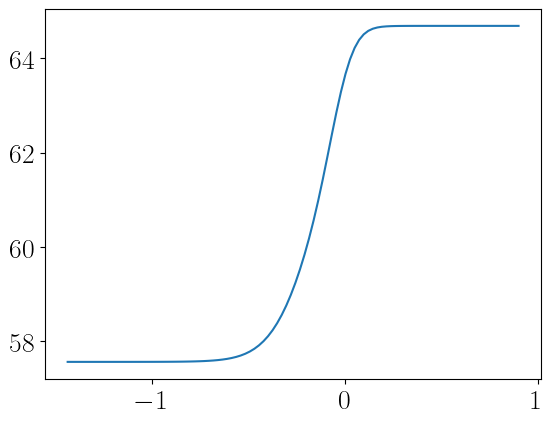

In [91]:
plt.plot(z_range, T_sol)

## Loop over velocities

In [41]:
vwlist = np.linspace(0.1,0.6,6)
Plist = np.ones((6,))

In [63]:
for γ in range(6):
    vw = round(vwlist[γ],2)
    print("Solve for vw = " + str(vw))
    Tm = optimize.newton(lambda T: find_Tsh(T, vw)-Tnuc, Tnuc-1)
    print("Tm = " +str(Tm))
    vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tm, hv, lv),[0.3, Tnuc], xtol=1e-10)
    hv_new = m.findMinimum(hv, Tp)
    lv_new = m.findMinimum(lv, Tm)
    h0 = lv_new[0]
    s0 = lv_new[1]-hv_new[1]
    s_initial=hv_new[1]
    def h_profile(z,Lh):
        z = np.asanyarray(z)
        hz = 0.5*h0*(1-np.tanh(z/Lh))
        return hz

    def s_profile(z, Ls, deltas):
        z = np.asanyarray(z)
        sz = 0.5*s0*(1-np.tanh(z/Ls + deltas)) + s_initial
        return sz

    def dh(z, Lh):
        z = np.asanyarray(z)
        return -0.5*(h0*Sech(z/Lh)**2)/Lh

    def ds(z, Ls, deltas):
        z = np.asanyarray(z)
        return -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls

    def d2h(z, Lh):
        z = np.asanyarray(z)
        return (h0*Sech(z/Lh)**2*Tanh(z/Lh))/Lh**2

    def d2s(z, Ls, deltas):
        z = np.asanyarray(z)
        return (s0*Sech(deltas + z/Ls)**2*Tanh(deltas + z/Ls))/Ls**2

    c1 = w(Vtot, Tm, lv_new) * vw/(1-vw**2)
    s1=c1
    c2=-Vtot(lv_new, Tm)+ w(Vtot, Tm, lv_new) * vw**2 /(1-vw**2)
    s2=c2

    def T33(T,z, Lh, Ls, deltas):
        derh = dh(z, Lh)
        ders = ds(z, Ls, deltas)
        field_value = [h_profile(z, Lh), s_profile(z, Ls, deltas)]
        return (0.5*(derh**2 + ders**2) - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6
    print("T33 defined. Solve moments.")
    def moments(Lh, Ls, deltas):
        npoints = 100
        z_range = np.linspace(-8*max(Lh,Ls), 5*max(Lh,Ls), npoints)
        T_sol = np.zeros((npoints,))
        for i in range(npoints):
            T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), 55, method='Nelder-Mead', bounds=[(40,90)])
            if T33min.fun > 0:
                T_sol[i]=T33min.x[0]
            else:
                try:
                    s = optimize.newton(lambda T: T33(T, z_range[i], Lh, Ls, deltas), Tnuc)
                except:
                    s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), Tnuc)[0]
                T_sol[i] = s

        hvalues = h_profile(z_range, Lh)
        svalues = s_profile(z_range, Ls, deltas)
        fields = np.array([hvalues, svalues]).T
        dV = m.gradV(fields, T_sol)
        Eh = dV[:,0] - d2h(z_range, Lh)
        Es = dV[:,1] - d2s(z_range, Ls, deltas)
        Ph = np.trapz(- Eh * dh(z_range, Lh), z_range)
        Gh = np.trapz(- Eh * dh(z_range, Lh) * np.tanh(z_range/Lh), z_range)
        Ps = np.trapz(- Es * ds(z_range, Ls, deltas), z_range)
        Gs = np.trapz(- Es * ds(z_range, Ls, deltas) * np.tanh(z_range/Ls + deltas), z_range)
        return np.array([Ph, Ps, Gh, Gs])/1e6
    
    def moments_match(L):
        Ph, Ps, Gh, Gs = moments(L[0], L[1], L[2])
        return np.array([Ph - Ps, Gh, Gs])
    
    Lsol = optimize.fsolve(lambda L: moments_match(L), [0.18, 0.17,0.35])
    print('Wall width solved.')
    print(str(Lsol))

    Ptot = 2*moments(Lsol[0], Lsol[1], Lsol[2])[0]
    Plist[γ] = Ptot
    print("Total P = " + str(Ptot))
    

Solve for vw = 0.1
Tm = 60.642392520620625
T33 defined. Solve moments.
Wall width solved.
[0.18585993 0.16770848 0.345005  ]
Total P = -3.1297856237579924
Solve for vw = 0.2
Tm = 61.111512348423354
T33 defined. Solve moments.
Wall width solved.
[0.1811608  0.16457373 0.33752687]
Total P = -2.7300262080121813
Solve for vw = 0.3
Tm = 61.6288703715139
T33 defined. Solve moments.
Wall width solved.
[0.17462309 0.16028366 0.32523458]
Total P = -2.1628227061836447
Solve for vw = 0.4
Tm = 61.99246015814873
T33 defined. Solve moments.
Wall width solved.
[0.16820435 0.15642541 0.30673968]
Total P = -1.4182957184522862
Solve for vw = 0.5
Tm = 59.97141256893064
T33 defined. Solve moments.
Wall width solved.
[0.17519192 0.16235413 0.29338787]
Total P = -1.1602543758851953
Solve for vw = 0.6
Tm = 54.67443812198635
T33 defined. Solve moments.
Wall width solved.
[0.29122481 0.25783815 0.29827898]
Total P = -1.123820955367603


In [74]:
cs_sq(Vtot, Tm, lv_new)**0.5

0.5388302964743242

In [76]:
vp

0.305962002496128

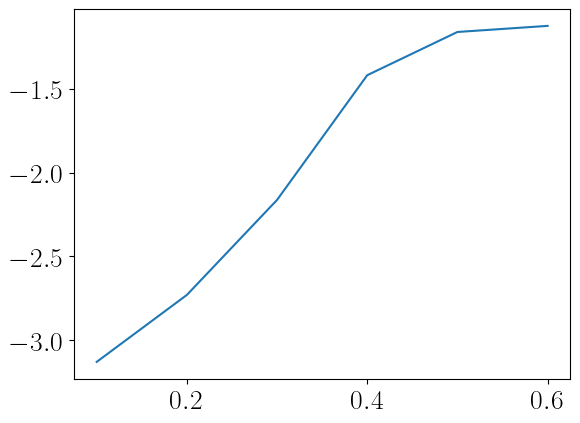

In [57]:
plt.plot(vwlist, Plist)

In [59]:
Tp

65.7531794564625

In [60]:
alpha_p(Vtot, Tp, Tm, hv_new, lv_new)

0.09110913673820151